In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import torch



import yfinance as yf


from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential 
from keras.layers import CuDNNLSTM

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [6]:
df = yf.download(tickers='TSLA', period = '24h', interval = '1m')

[*********************100%***********************]  1 of 1 completed


In [7]:
#QUANDL_API_KEY = 'LxKqezodnpFh1HWNNzgs'
#quandl.ApiConfig.api_key = QUANDL_API_KEY 

# Set the start and end date
#start_date = '2010-03-25'
#end_date = '2019-01-24'

# Set the ticker name
#ticker = 'MSFT'

# Feth the data
#df = quandl.get('WIKI/'+ticker, 
#                  start_date=start_date, 
#                  end_date=end_date, 
#                  api_key=QUANDL_API_KEY)

In [8]:
df = df.sort_values('Datetime')

In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-28 09:30:00-04:00,1065.099976,1068.500000,1057.500000,1063.989990,1063.989990,3289164
2022-03-28 09:31:00-04:00,1064.040039,1070.000000,1059.890015,1062.848999,1062.848999,283958
2022-03-28 09:32:00-04:00,1063.000000,1063.000000,1056.750000,1060.219971,1060.219971,237168
2022-03-28 09:33:00-04:00,1060.454956,1061.839966,1053.599976,1058.989990,1058.989990,276402
2022-03-28 09:34:00-04:00,1056.000000,1056.000000,1055.000000,1055.633301,1055.633301,180339


In [10]:
df.shape

(263, 6)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

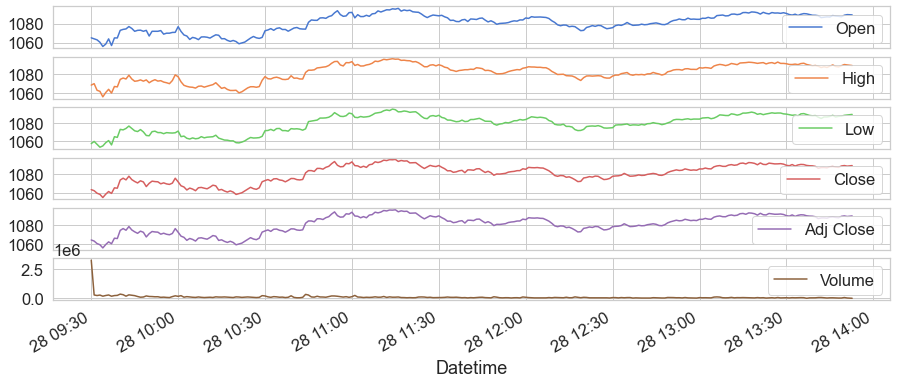

In [11]:
#ax = df.plot(x=['Datetime'], y=['Close']);
#ax.set_xlabel("Datetime")
#ax.set_ylabel("Close Price (USD)")
df.plot(subplots=True, figsize=(15,6))

In [12]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [13]:
scaled_close.shape

(263, 1)

In [14]:
np.isnan(scaled_close).any()

False

In [15]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [16]:
scaled_close = scaled_close.reshape(-1, 1)

In [17]:
np.isnan(scaled_close).any() #check for any NaN's (non intger numbers or something)

False

In [18]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [19]:
X_train.shape

(154, 99, 1)

In [20]:
X_test.shape

(9, 99, 1)

In [21]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [22]:
#model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                       # input_shape=(WINDOW_SIZE, X_train.shape[-1])))


In [23]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [25]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
3/3 [==============================] - 0s 75ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 2/50
3/3 [==============================] - 0s 59ms/step - loss: 0.0036 - val_loss: 4.9317e-04
Epoch 3/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0032 - val_loss: 5.5701e-04
Epoch 5/50
3/3 [==============================] - 0s 57ms/step - loss: 0.0033 - val_loss: 5.8942e-04
Epoch 6/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 7/50
3/3 [==============================] - 0s 58ms/step - loss: 0.0030 - val_loss: 5.6797e-04
Epoch 8/50
3/3 [==============================] - 0s 51ms/step - loss: 0.0029 - val_loss: 4.6923e-04
Epoch 9/50
3/3 [==============================] - 0s 58ms/step - loss: 0.0029 - val_loss: 8.2447e-04
Epoch 10/50
3/3 [==============================] - 0s 58ms/step - loss: 0.0025 - val_loss: 4.8563e-04
E

In [26]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 80ms/step - loss: 0.0015


0.0014660353772342205

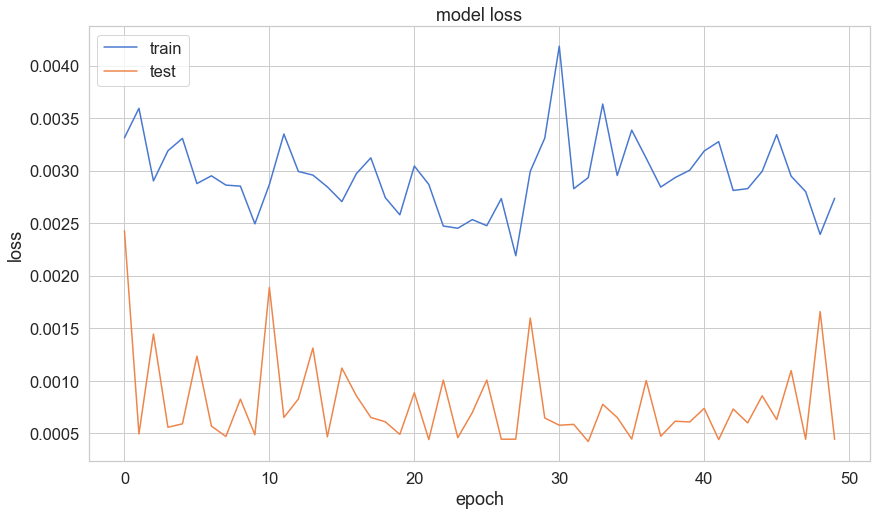

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

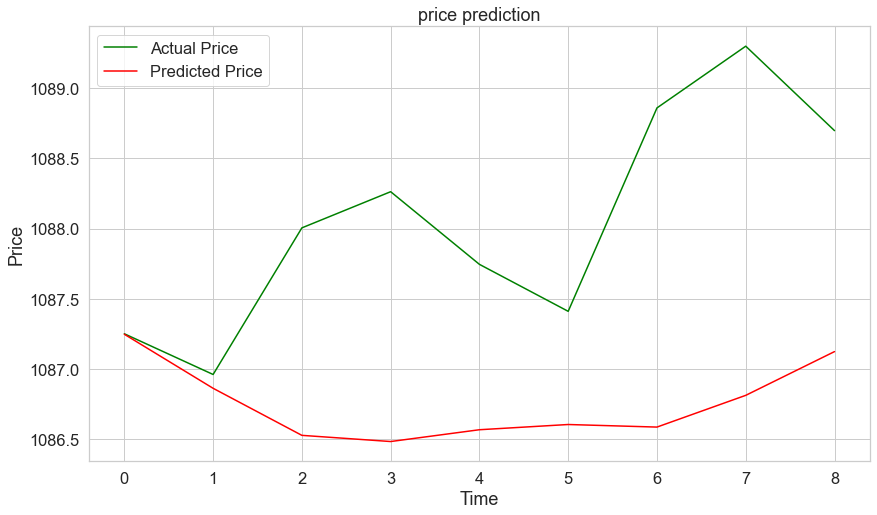

In [28]:
y_hat = model.predict(X_test)
train_predict = model.predict(X_train)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

NameError: name 'ds_scaled' is not defined

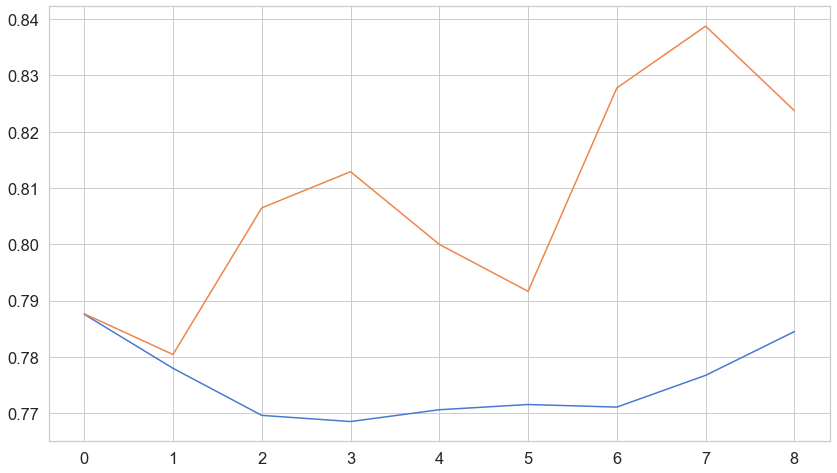

In [29]:
plt.plot(y_hat)
plt.plot(y_test)
plt.plot(scaler.inverse_transform(ds_scaled))

In [30]:
shift_days = 1
shift_steps = shift_days * 24  # predicts 24 hours into the future? if want 7 days then 24 x 7 
df_targets = df.shift(-shift_steps)

In [31]:
df.head(shift_steps + 5)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-28 09:30:00-04:00,1065.099976,1068.500000,1057.500000,1063.989990,1063.989990,3289164
2022-03-28 09:31:00-04:00,1064.040039,1070.000000,1059.890015,1062.848999,1062.848999,283958
2022-03-28 09:32:00-04:00,1063.000000,1063.000000,1056.750000,1060.219971,1060.219971,237168
2022-03-28 09:33:00-04:00,1060.454956,1061.839966,1053.599976,1058.989990,1058.989990,276402
2022-03-28 09:34:00-04:00,1056.000000,1056.000000,1055.000000,1055.633301,1055.633301,180339
2022-03-28 09:35:00-04:00,1058.500000,1060.589966,1058.500000,1059.180054,1059.180054,239801
2022-03-28 09:36:00-04:00,1064.000000,1064.000000,1060.810059,1062.000000,1062.000000,284452
2022-03-28 09:37:00-04:00,1057.000000,1059.999878,1056.099976,1059.999878,1059.999878,177568
2022-03-28 09:38:00-04:00,1065.000000,1067.000000,1065.000000,1065.839966,1065.839966,233138


In [32]:
df_targets.head(5)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-28 09:30:00-04:00,1072.750000,1073.189941,1069.500000,1070.099854,1070.099854,81387.0
2022-03-28 09:31:00-04:00,1069.000000,1071.699951,1068.300049,1071.099976,1071.099976,97073.0
2022-03-28 09:32:00-04:00,1070.000000,1070.999878,1069.449951,1070.000000,1070.000000,74738.0
2022-03-28 09:33:00-04:00,1070.000000,1070.010010,1069.150024,1069.469971,1069.469971,62376.0
2022-03-28 09:34:00-04:00,1070.800049,1073.310059,1069.000000,1070.800049,1070.800049,143966.0


In [33]:
df_targets.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-28 13:48:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 13:49:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 13:50:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 13:51:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 13:52:42-04:00,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
x_data = df.values[0:-shift_steps] #input singals 

In [35]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (239, 6)


In [36]:
y_data = df_targets.values[:-shift_steps] #output/target singals
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (239, 6)


In [37]:
#number of observations
num_data = len(x_data) 
num_data

239

In [38]:
#This is the fraction of the data-set that will be used for the training-set:
train_split = 0.9

In [39]:
#This is the number of observations in the training-set:
num_train = int(train_split * num_data)
num_train

215

In [40]:
#This is the number of observations in the test-set:
num_test = num_data - num_train
num_test

24

In [41]:
#These are the input-signals for the training- and test-sets:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

239

In [42]:
#These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

239

In [43]:
num_x_signals = x_data.shape[1] #This is the number of input-signals:
num_x_signals

6

In [44]:
num_y_signals = y_data.shape[1] #This is the number of output-signals:
num_y_signals

6

In [45]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 1053.5999755859375
Max: 3289164.0


In [46]:
x_scaler = MinMaxScaler()

In [47]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [48]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [49]:
x_test_scaled = x_scaler.transform(x_test)

In [50]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [51]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(215, 6)
(215, 6)


In [52]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

batch_size = 256
sequence_length = 2 * 7 * 8

In [53]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [54]:

x_batch, y_batch = next(generator)


In [55]:
print(x_batch.shape)
print(y_batch.shape)

(256, 112, 6)
(256, 112, 6)


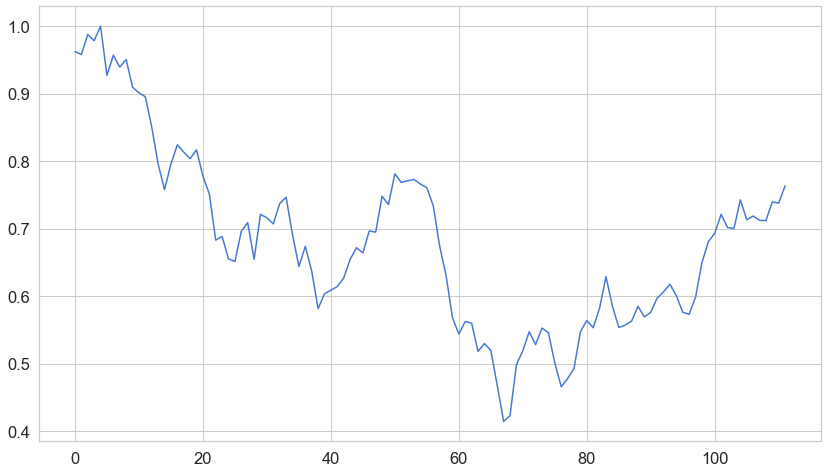

In [56]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

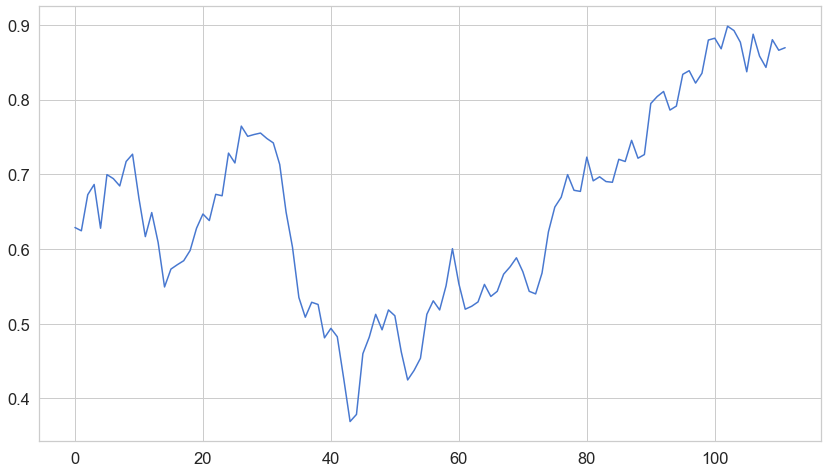

In [57]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [58]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [59]:
from tensorflow.keras.models import Sequential 

from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

In [60]:
model = Sequential()

In [61]:

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [62]:
model.add(Dense(num_y_signals, activation='sigmoid'))


In [63]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [64]:
warmup_steps = 50

In [65]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [66]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

C:\Users\gseid\.conda\envs\tensorflow2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [67]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [68]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         798720    
_________________________________________________________________
dense_1 (Dense)              (None, None, 6)           3078      
Total params: 801,798
Trainable params: 801,798
Non-trainable params: 0
_________________________________________________________________


In [69]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [70]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [71]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [72]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [73]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [74]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 10s 81ms/step - loss: 0.6091 - acc: 0.1996 - val_loss: 0.4692 - val_acc: 0.1667

Epoch 00001: val_loss improved from inf to 0.46916, saving model to 23_checkpoint.keras
Epoch 2/20
100/100 [==============================] - 8s 77ms/step - loss: 0.5913 - acc: 0.2052 - val_loss: 0.4628 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.46916 to 0.46283, saving model to 23_checkpoint.keras
Epoch 3/20
100/100 [==============================] - 8s 78ms/step - loss: 0.5773 - acc: 0.2013 - val_loss: 0.4718 - val_acc: 0.3333

Epoch 00003: val_loss did not improve from 0.46283

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
100/100 [==============================] - 8s 78ms/step - loss: 0.5587 - acc: 0.2475 - val_loss: 0.4670 - val_acc: 0.1667

Epoch 00004: val_loss did not improve from 0.46283

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 5/20
100/100 [=========

In [75]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [76]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 20ms/step - loss: 0.4628 - acc: 0.0000e+00


In [77]:
print("loss (test-set):", result)

loss (test-set): [0.4628320038318634, 0.0]


In [78]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [79]:
def generate_predictions(start_idx, length=100, train=False,forecast = False):
    
    
    if forecast:
        x = x_test_scaled.copy()
    
    elif train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    if forecast:
        x = x[start_idx:end_idx]
        
    else:
        x = x[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    pred_dict = {i: None for i in target_names} 
    
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        pred_dict[target_names[signal]] = signal_pred
        
    return pred_dict

In [80]:
target_names = ['x','y','z']

pred_dict = generate_predictions(start_idx=0, length=10000, train=True, forecast = False)

In [81]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-28 09:30:00-04:00,1065.099976,1068.500000,1057.500000,1063.989990,1063.989990,3289164
2022-03-28 09:31:00-04:00,1064.040039,1070.000000,1059.890015,1062.848999,1062.848999,283958
2022-03-28 09:32:00-04:00,1063.000000,1063.000000,1056.750000,1060.219971,1060.219971,237168
2022-03-28 09:33:00-04:00,1060.454956,1061.839966,1053.599976,1058.989990,1058.989990,276402
2022-03-28 09:34:00-04:00,1056.000000,1056.000000,1055.000000,1055.633301,1055.633301,180339


In [82]:
def plot_comparison(start_idx, length=100, train=False,forecast = False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if forecast:
        x = x_test_scaled.copy()
    
    elif train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    if forecast:
        x = x[start_idx:end_idx]
        
    else:
        x = x[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    pred_dict = {i: None for i in target_names} 
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        pred_dict[target_names[signal]] = signal_pred
        if forecast == False:
            # Get the true output-signal from the data-set.
            signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        if forecast == False:
            
            # Plot and compare the two signals.
            plt.plot(signal_true, label='true')
        
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
        
        return signal

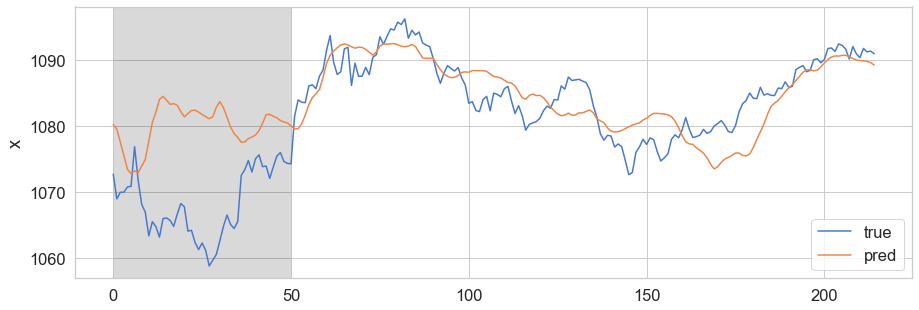

0

In [83]:
plot_comparison(start_idx=0, length=10000, train=True, forecast = False)

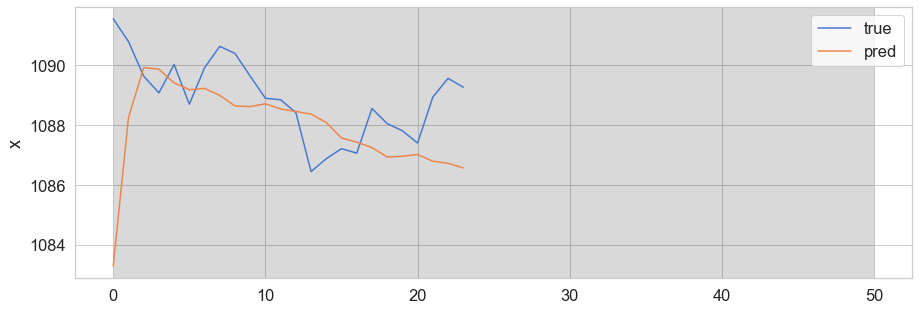

0

In [84]:
plot_comparison(start_idx=0, length=10000, train=False, forecast = False)

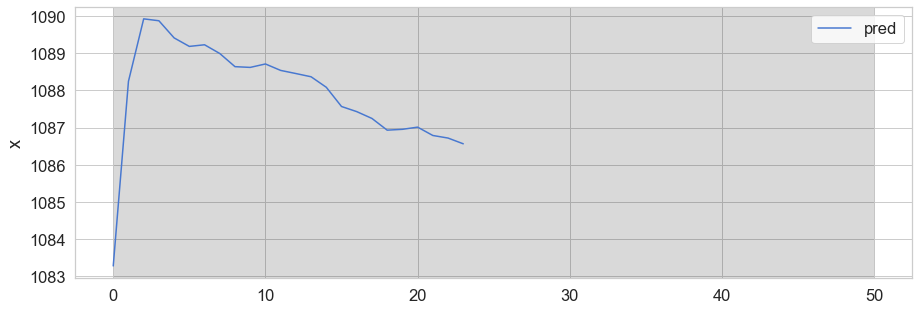

0

In [85]:
plot_comparison(start_idx=0, length=1000, train=False,forecast = True)

In [86]:
# https://github.com/Saran-nns/device_tracking/blob/master/predict_future_coordinates_DRNN.ipynb

In [87]:
#https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In [88]:
#END 

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

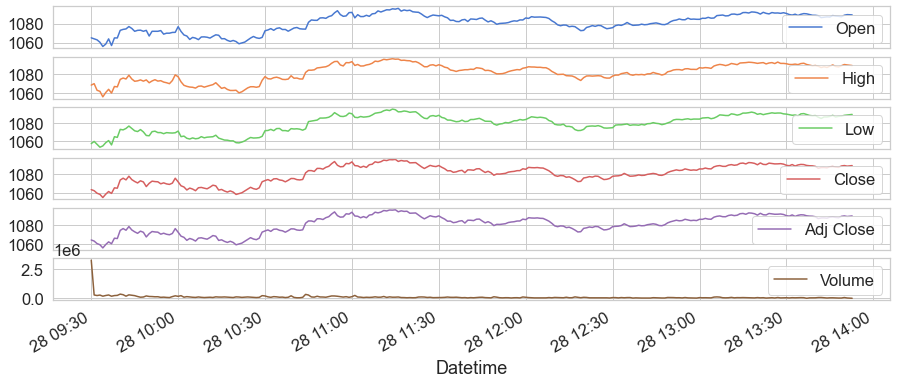

In [89]:
df.plot(subplots=True, figsize=(15,6))

TypeError: cannot perform __mod__ with this index type: DatetimeArray

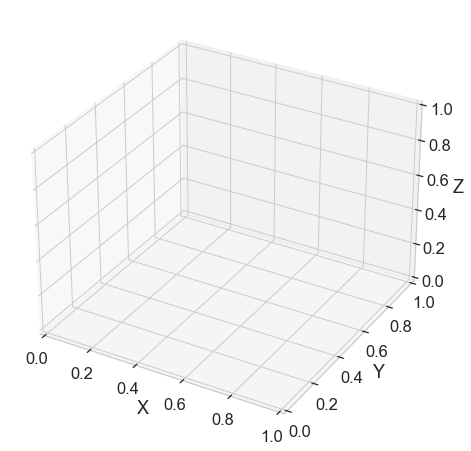

In [145]:
def update_graph(num):
    
    if num == 1000:
        graph._offsets3d = (data.x, data.y, data.z)
        
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



df = df[df.index % 5 == 0]
    
graph = ax.scatter(df.x[0:1000], df.y[0:1000], df.z[0:1000])

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 
                               interval=1000, blit=False,repeat = False, )

plt.show()